In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
data = pd.read_csv("AggregatedData.csv")

<h3> Convert Weekday column to Uppercase because of format mismatch </h3>

In [3]:
data['Weekday'] = data['Weekday'].str.upper()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11589 entries, 0 to 11588
Data columns (total 12 columns):
ATM Name                        11589 non-null object
Transaction Date                11589 non-null object
No Of Withdrawals               11589 non-null int64
No Of XYZ Card Withdrawals      11589 non-null int64
No Of Other Card Withdrawals    11589 non-null int64
Total amount Withdrawn          11589 non-null int64
Amount withdrawn XYZ Card       11589 non-null int64
Amount withdrawn Other Card     11589 non-null int64
Weekday                         11589 non-null object
Festival Religion               11589 non-null object
Working Day                     11589 non-null object
Holiday Sequence                11589 non-null object
dtypes: int64(6), object(6)
memory usage: 1.1+ MB


<h3> Convert Transaction Date column to Date Time object </h3>

In [5]:
import datetime 
data['Transaction Date'] = pd.to_datetime(data['Transaction Date']) 

In [6]:
data.head()

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,2011-01-01,50,20,30,123800,41700,82100,SATURDAY,H,H,WHH
1,Mount Road ATM,2011-01-01,253,67,186,767900,270900,497000,SATURDAY,C,H,WHH
2,Airport ATM,2011-01-01,98,56,42,503400,347700,155700,SATURDAY,C,H,WHH
3,KK Nagar ATM,2011-01-01,265,159,106,945300,532600,412700,SATURDAY,C,H,WHH
4,Christ College ATM,2011-01-01,74,25,49,287700,148200,139500,SATURDAY,C,H,WHH


<h3> Removing the XYZ and Other Card Withdrawn Amounts columns too because I think they will end up biasing the model too much because the Total Amount Withdrawn column is just the sum of these two columns </h3>
<h4> Actually the number of withdrawals should be removed too, because in a real-time scenario, we cannot really have that value but I'm keeping it in for now </h4>

In [7]:
new_data = data.drop(['Transaction Date', 'Amount withdrawn Other Card',
               'Amount withdrawn XYZ Card', 'No Of Withdrawals', 'No Of XYZ Card Withdrawals',
       'No Of Other Card Withdrawals'], axis = 1)

# y = data['Total amount Withdrawn']

<h3> Converting Transaction Date to separate columns, otherwise model won't accept it </h3>


In [8]:
new_data['Month'] = data['Transaction Date'].dt.month
new_data['Day'] = data['Transaction Date'].dt.day
new_data['Year'] = data['Transaction Date'].dt.year

In [9]:
new_data.columns

Index(['ATM Name', 'Total amount Withdrawn', 'Weekday', 'Festival Religion',
       'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year'],
      dtype='object')

<h3> Converting Categorical Columns to Boolean Columns using pd.get_dummies() </h3>

In [10]:
categorical_features_list = ['ATM Name', 'Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
numeric_features_list = []

In [63]:
# Convert all categorical columns to Dummy Data (One-Hot Encoding I think)
# drop_first = True to avoid the first column of each dummy column's result
# So if column = Gender and has two unique values Male and Female, get_dummies on this column creates two new columns
# male and female, if person male that column is 1 and the other is 0 and same for female column, but we only just need
# one of these columns, male or female, if male is 0 it guarantees person is female, for that reason drop_first=True
def convert_categorical_to_numerical(data, column_list):
    return pd.get_dummies(data, columns=column_list, drop_first=True)

# numeric_data = pd.get_dummies(new_data, columns=categorical_features_list, drop_first=True)
numeric_data = convert_categorical_to_numerical(new_data, categorical_features_list)

In [64]:
numeric_data.head()

,Total amount Withdrawn,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_KK Nagar ATM,ATM Name_Mount Road ATM,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,...,Day_28,Day_29,Day_30,Day_31,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017
0,123800,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,767900,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,503400,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,945300,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3> Train Test Split followed by Scaling all Columns </h3>
<h3> Since all columns are non-numeric, we don't really need scaling, so I commented it out for now </h3>

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = numeric_data.drop('Total amount Withdrawn', axis=1)
y = numeric_data['Total amount Withdrawn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Note that we fit the scaler on X_train only and not X, otherwise test data will get biased on means and std of test data
# Instead it should use train data mean and std
# scaler = StandardScaler().fit(X_train)
# scaled_X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)
# scaled_X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

# scaled_X_train

<h3> KNN Implementation & Error Rate Visualization </h3>

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

error_rate = []
for k in range(1, 51):
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    error_rate.append(np.sqrt(mean_squared_error(y_test, predictions)))
    print("k={} Model Trained and Tested".format(k))

k=1 Model Trained and Tested
k=2 Model Trained and Tested
k=3 Model Trained and Tested
k=4 Model Trained and Tested
k=5 Model Trained and Tested
k=6 Model Trained and Tested
k=7 Model Trained and Tested
k=8 Model Trained and Tested
k=9 Model Trained and Tested
k=10 Model Trained and Tested
k=11 Model Trained and Tested
k=12 Model Trained and Tested
k=13 Model Trained and Tested
k=14 Model Trained and Tested
k=15 Model Trained and Tested
k=16 Model Trained and Tested
k=17 Model Trained and Tested
k=18 Model Trained and Tested
k=19 Model Trained and Tested
k=20 Model Trained and Tested
k=21 Model Trained and Tested
k=22 Model Trained and Tested
k=23 Model Trained and Tested
k=24 Model Trained and Tested
k=25 Model Trained and Tested
k=26 Model Trained and Tested
k=27 Model Trained and Tested
k=28 Model Trained and Tested
k=29 Model Trained and Tested
k=30 Model Trained and Tested
k=31 Model Trained and Tested
k=32 Model Trained and Tested
k=33 Model Trained and Tested
k=34 Model Trained 

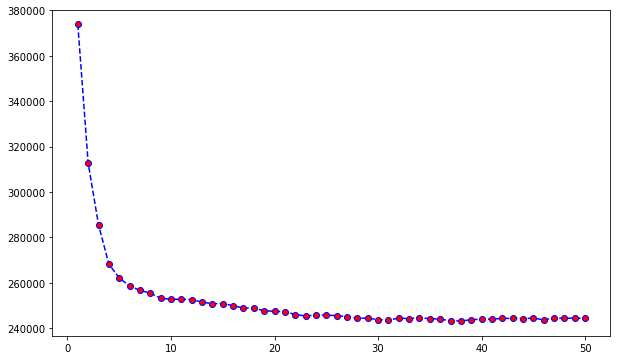

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(1,51), error_rate, linestyle='--', marker='o', markerfacecolor='red', color='blue')

In [16]:
print("Best K:", error_rate.index(min(error_rate)))
print("Best RMSE:", min(error_rate))

Best K: 37
Best RMSE: 243180.0491744677


<h3> Best RMSE: 243180.0491744677 </h3>

<h2> Linear Regression </h2>

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)

lr.fit(X_train, y_train)

lr_predictions = lr.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print(lr_rmse)

251419.81922358868


<h3> Linear Regression RMSE: 251419.81922358868 </h3>

<h2> Ridge Linear Regression </h2>

In [18]:
from sklearn.linear_model import Ridge

# Potential to use Hyperparameter Tuning with solvers, alpha
ridge_lr = Ridge()

ridge_lr.fit(X_train, y_train)

ridge_lr_predictions = ridge_lr.predict(X_test)

ridge_lr_rmse = np.sqrt(mean_squared_error(y_test, ridge_lr_predictions))

print(ridge_lr_rmse)

251386.47604234665


<h3> Ridge Linear Regression RMSE: 251386.47604234665 </h3>

<h2> Lasso Linear Regression </h2>

In [19]:
from sklearn.linear_model import Lasso

# Potential to use Hyperparameter Tuning with alpha
lasso_lr = Lasso(max_iter=1100)

lasso_lr.fit(X_train, y_train)

lasso_lr_predictions = lasso_lr.predict(X_test)

lasso_lr_rmse = np.sqrt(mean_squared_error(y_test, lasso_lr_predictions))

print(lasso_lr_rmse)
print(lasso_lr.n_iter_)

251415.86960634057
1091


<h3> Lasso Linear Regression RMSE: 251415.86960634057 </h3>

<h2> Bayesian Ridge Linear Regression </h2>

In [20]:
from sklearn.linear_model import BayesianRidge

# Lot of potential to use Hyperparameter Tuning with alpha_1, 2, lambda_1, lambda_2 
bayes_ridge_lr = BayesianRidge()

bayes_ridge_lr.fit(X_train, y_train)

bayes_ridge_lr_predictions = bayes_ridge_lr.predict(X_test)

bayes_ridge_lr_rmse = np.sqrt(mean_squared_error(y_test, bayes_ridge_lr_predictions))

print(bayes_ridge_lr_rmse)

251396.25827460986


<h3> Bayesian Ridge Linear Regression RMSE: 251396.25827460986 </h3>

<h2> Elasticnet Linear Regression </h2>

In [21]:
from sklearn.linear_model import ElasticNet

# Potential to use Hyperparameter Tuning with alpha and l1_ratio
enet_lr = ElasticNet()

enet_lr.fit(X_train, y_train)

enet_lr_predictions = enet_lr.predict(X_test)

enet_lr_rmse = np.sqrt(mean_squared_error(y_test, enet_lr_predictions))

print(enet_lr_rmse)

299840.48379522713


<h3> Elasticnet Linear Regression RMSE: 299840.48379522713 </h3>

<h2> Support Vector Regression </h2>

In [22]:
from sklearn.svm import SVR

# Potential to use Hyperparameter Tuning with kernel and C
svr = SVR()

svr.fit(X_train, y_train)

svr_predictions = svr.predict(X_test)

svr_rmse = np.sqrt(mean_squared_error(y_test, svr_predictions))

print(svr_rmse)

330051.3590919249


<h3> Support Vector Regression RMSE: 330051.3590919249 </h3>

<h2> Decision Tree Regression </h2>

In [23]:
from sklearn.tree import DecisionTreeRegressor

# Lord knows how to Hyperparameter this, so many features
dtree_reg = DecisionTreeRegressor()

dtree_reg.fit(X_train, y_train)

dtree_reg_predictions = dtree_reg.predict(X_test)

dtree_reg_rmse = np.sqrt(mean_squared_error(y_test, dtree_reg_predictions))

print(dtree_reg_rmse)

259317.89328649253


<h3> Decision Tree Regression RMSE: Varies with each execution but range from 255000 to 257000 </h3>

<h2> Random Forest Regression </h2>

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

rf_reg_predictions = rf_reg.predict(X_test)

rf_reg_rmse = np.sqrt(mean_squared_error(y_test, rf_reg_predictions))

print(rf_reg_rmse)

207293.77187090286


<h3> Random Forest Regression RMSE: Varies with each execution but ranges from 205500 to 207200 </h3>

<h2> Running all models to get summary of all RMSEs </h2>

In [25]:
models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}

In [79]:
def compute_rmse_model_list(models, X_train, y_train, X_test, y_test):
    print("RMSEs for each model")
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        model_predictions = model.predict(X_test)
        model_rmse = np.sqrt(mean_squared_error(y_test, model_predictions))
        model_testing_score = model.score(X_test, y_test)
        model_training_score = model.score(X_train, y_train)
        print("For", model_name)
        print("\tTesting RMSE = {}".format(model_rmse))
        print("\tTraining Score =", model_training_score)
        print("\tTesting Score =", model_testing_score)

In [27]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 243308.4815900565
	Training Score = 0.45697266653028884
	Testing Score = 0.4469533394817221
For Vanilla Linear Regression
	Testing RMSE = 251419.81922358868
	Training Score = 0.4013361571445507
	Testing Score = 0.409464110262857
For Ridge Linear Regression
	Testing RMSE = 251386.47604234665
	Training Score = 0.4013043683235682
	Testing Score = 0.4096207330748531
For Elasticnet Linear Regression
	Testing RMSE = 299840.48379522713
	Training Score = 0.1599098376804099
	Testing Score = 0.16009954359397116
For Lasso Linear Regression
	Testing RMSE = 251415.86960634057
	Training Score = 0.4013359783757806
	Testing Score = 0.40948266387110405
For Bayesian Ridge Linear Regression
	Testing RMSE = 251396.25827460986
	Training Score = 0.4006642870319033
	Testing Score = 0.40957478518163776
For Support Vector Regression
	Testing RMSE = 330051.3590919249
	Training Score = -0.023764153336445215
	Testing Score = -0.01767786439476282
For Ra

<h4> After observing the testing and training scores, I think its clear that Decision Tree overfits, but I dont think that was ever that high on our sought after models list, so that's good, other than that everything is not ideal but atleast no overfitting </h4>

<h3> Using only 2017 data as test data and everything else as training data </h3>

In [28]:
numeric_data

,Total amount Withdrawn,ATM Name_Big Street ATM,ATM Name_Christ College ATM,ATM Name_KK Nagar ATM,ATM Name_Mount Road ATM,Weekday_MONDAY,Weekday_SATURDAY,Weekday_SUNDAY,Weekday_THURSDAY,Weekday_TUESDAY,...,Day_28,Day_29,Day_30,Day_31,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017
0,123800,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,767900,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,503400,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,945300,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,287700,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11584,468800,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11585,305100,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11586,709900,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
11587,408700,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [29]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data['Year_2017'] == 1]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

10434
1155


In [30]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 370654.38876929344
	Training Score = 0.49334898232826474
	Testing Score = -0.2036759694108361
For Vanilla Linear Regression
	Testing RMSE = 351236.1852653552
	Training Score = 0.4535210215154458
	Testing Score = -0.08086088361456811
For Ridge Linear Regression
	Testing RMSE = 350930.3772714196
	Training Score = 0.4534927053204132
	Testing Score = -0.07897957400080258
For Elasticnet Linear Regression
	Testing RMSE = 343651.78719365434
	Training Score = 0.18540431599596496
	Testing Score = -0.03468585104161148
For Lasso Linear Regression
	Testing RMSE = 351207.1555167714
	Training Score = 0.4535207164047764
	Testing Score = -0.08068222421466187
For Bayesian Ridge Linear Regression
	Testing RMSE = 349989.46216254827
	Training Score = 0.4530724819355578
	Testing Score = -0.07320140697245625
For Support Vector Regression
	Testing RMSE = 339522.5629301751
	Training Score = -0.025059950311879797
	Testing Score = -0.0099702418425564

<h3> Random Forest and Decision Tree overfit here but everything else is trash for both training and testing, idk what can be done about this </h3>

<h3> Finding out the total amount withdrawn per month per year </h3>

In [46]:
new_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
1,Mount Road ATM,767900,SATURDAY,C,H,WHH,1,1,2011
2,Airport ATM,503400,SATURDAY,C,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
4,Christ College ATM,287700,SATURDAY,C,H,WHH,1,1,2011
...,...,...,...,...,...,...,...,...,...
11584,Big Street ATM,468800,FRIDAY,H,H,WHH,9,29,2017
11585,Mount Road ATM,305100,FRIDAY,H,H,WHH,9,29,2017
11586,Airport ATM,709900,FRIDAY,H,H,WHH,9,29,2017
11587,KK Nagar ATM,408700,FRIDAY,H,H,WHH,9,29,2017


In [32]:
# Takes like 15-20 seconds to compute
total_amt_per_mon_per_yr = {}
for year in new_data['Year'].unique():
    for month in new_data['Month'].unique():
        total_amt_per_mon_per_yr[(year, month)] = sum(new_data[new_data.apply(lambda x: x['Year'] == year
                            and x['Month'] == month, axis=1)]['Total amount Withdrawn'])

<p> total_amt_per_mon_per_yr is basically a dictionary whose key is a tuple (year, month) and its value contains the total amount withdrawn in the month of the year specified in the key, so (2011, 1): 65360200, means that 65360200 was withdrawn in total in the month of January 2011 </p>

In [33]:
from pprint import pprint

# Uncomment this if you want to see what the dictionary is like but its a big list and takes up space so I commented it out
# pprint(total_amt_per_mon_per_yr)

In [34]:
total_amount_withdrawn = sum(total_amt_per_mon_per_yr.values())
avg_amount_withdrawn = sum(total_amt_per_mon_per_yr.values()) / len(total_amt_per_mon_per_yr.values())
print("Total Amount Withdrawn:", total_amount_withdrawn)
print("Average Amount Withdrawn:", avg_amount_withdrawn)

Total Amount Withdrawn: 6053002800
Average Amount Withdrawn: 72059557.14285715


<h3> Figuring out Outlier Months </h3>
<p> So my logic is that I take the total amount withdrawn in each month (of each year ofc) and then check its difference from the average amount withdrawn per month per year, and there's a tolerance percent variable (currently 0.7), so if the difference (positive or negative) is greater than 70% of the avg_amount_withdrawn, then that month of that year is an outlier </p>
<p> I think something similar can be done with days in a month as well </p>

In [38]:
tolerance_percent = 0.7

for key in total_amt_per_mon_per_yr:
    amount = total_amt_per_mon_per_yr[key]
    if abs(amount - avg_amount_withdrawn) > avg_amount_withdrawn * tolerance_percent:
        print(key)
        # print(total_amt_per_mon_per_yr[key])

(2016, 11)
(2016, 12)
(2017, 10)
(2017, 11)
(2017, 12)


<h3> Removing outlier months from 2017 in test set </h3>

In [36]:
train_data = numeric_data[numeric_data['Year_2017'] == 0]
test_data = numeric_data[numeric_data.apply(lambda x: x['Year_2017'] == 1
                            and x['Month_10'] != 1 and x['Month_11'] != 1 and x['Month_12'] != 1, axis=1)]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']


10434
1053


In [37]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 372340.49206527043
	Training Score = 0.49334898232826474
	Testing Score = -0.2018997476884299
For Vanilla Linear Regression
	Testing RMSE = 351707.4107674948
	Training Score = 0.4535210215154458
	Testing Score = -0.07238503792997997
For Ridge Linear Regression
	Testing RMSE = 351434.1312815757
	Training Score = 0.4534927053204132
	Testing Score = -0.07071918178027703
For Elasticnet Linear Regression
	Testing RMSE = 345648.1068296639
	Training Score = 0.18540431599596496
	Testing Score = -0.03575269583521212
For Lasso Linear Regression
	Testing RMSE = 351681.79185469187
	Training Score = 0.4535207164047764
	Testing Score = -0.07222881524409619
For Bayesian Ridge Linear Regression
	Testing RMSE = 350577.01082009525
	Training Score = 0.4530724819355578
	Testing Score = -0.06550274948102763
For Support Vector Regression
	Testing RMSE = 341483.98469625093
	Training Score = -0.025059950311879797
	Testing Score = -0.010947000905629

<h3> A slight improvement but pretty insignificant sadly </h3>

<h3> Figuring out Outlier Days with 75% difference from the average amount withdrawn per day as the tolerance</h3>

In [47]:
avg_amount_withdrawn_per_day = sum(new_data['Total amount Withdrawn']) / len(new_data['Total amount Withdrawn'])
tolerance_percent = 0.75

outlier_day_data = new_data[new_data.apply(lambda x: abs(avg_amount_withdrawn_per_day - x['Total amount Withdrawn']) > 
                            avg_amount_withdrawn_per_day * tolerance_percent, axis=1)]

In [49]:
outlier_day_data

,ATM Name,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
0,Big Street ATM,123800,SATURDAY,H,H,WHH,1,1,2011
3,KK Nagar ATM,945300,SATURDAY,C,H,WHH,1,1,2011
5,Big Street ATM,52800,SUNDAY,NH,H,HHW,2,1,2011
10,Big Street ATM,88100,MONDAY,NH,W,WWW,3,1,2011
13,KK Nagar ATM,1333100,MONDAY,NH,W,WWW,3,1,2011
...,...,...,...,...,...,...,...,...,...
11558,Christ College ATM,1253100,SATURDAY,NH,H,WHH,9,23,2017
11567,KK Nagar ATM,1175200,MONDAY,NH,W,HWW,9,25,2017
11577,KK Nagar ATM,997800,WEDNESDAY,NH,W,WWW,9,27,2017
11582,KK Nagar ATM,1154900,THURSDAY,NH,W,WWH,9,28,2017


In [62]:
# Kinda useless, prints a really big list that's all
# for idx, row in outlier_day_data.iterrows():
#     print("{}, {}, {}".format(row['Year'], row['Month'], row['Day']))

<p> I used value_counts() on Month, Day and Year of the outlier df but it contains data of multiple ATMs, so I split them to figure out the actual numbers </p>

In [59]:
for bank in outlier_day_data['ATM Name'].unique():
    print("For Bank:", bank)
    print(outlier_day_data[outlier_day_data['ATM Name'] == bank]['Month'].value_counts(), "\n")

For Bank: Big Street ATM
11    42
3     42
4     40
1     40
7     38
8     34
2     34
6     31
5     27
12    25
10    22
9     20
Name: Month, dtype: int64 

For Bank: KK Nagar ATM
1     95
5     85
8     84
10    83
7     83
11    82
3     82
6     78
4     77
2     76
9     74
12    69
Name: Month, dtype: int64 

For Bank: Christ College ATM
5     38
1     35
4     34
3     33
10    29
8     26
7     26
6     26
2     24
11    16
9     15
12    10
Name: Month, dtype: int64 

For Bank: Airport ATM
1     23
7     22
5     19
3     18
6     17
2     17
11    16
10    16
4     15
9     14
8     14
12    11
Name: Month, dtype: int64 

For Bank: Mount Road ATM
6     40
4     39
5     36
3     36
1     34
8     26
7     25
11    24
10    22
2     20
9     14
12    11
Name: Month, dtype: int64 



<h3> Basically KK Nagar ATM has vastly large number of outlier days as compared to the others and Airport ATM is the best in this regard </h3>

In [61]:
for bank in outlier_day_data['ATM Name'].unique():
    print("For Bank:", bank)
    print(outlier_day_data[outlier_day_data['ATM Name'] == bank]['Year'].value_counts(), "\n")

For Bank: Big Street ATM
2011    243
2012     78
2016     30
2017     24
2014      8
2015      7
2013      5
Name: Year, dtype: int64 

For Bank: KK Nagar ATM
2013    260
2014    258
2012    157
2016     86
2017     85
2015     69
2011     53
Name: Year, dtype: int64 

For Bank: Christ College ATM
2017    92
2014    75
2016    69
2015    34
2013    19
2012    12
2011    11
Name: Year, dtype: int64 

For Bank: Airport ATM
2016    68
2017    54
2015    35
2014    17
2013    14
2012    11
2011     3
Name: Year, dtype: int64 

For Bank: Mount Road ATM
2016    106
2015     54
2014     54
2017     50
2012     30
2013     24
2011      9
Name: Year, dtype: int64 



<h3> Trying to build Hail Mary model on Airport ATM data </h3>

In [67]:
airport_data = new_data[new_data['ATM Name'] == 'Airport ATM'].drop('ATM Name', axis=1)

categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']

numeric_airport_data = convert_categorical_to_numerical(airport_data, categorical_features_list)

<h3> 2017 Data as Test and rest as Train, for handling outliers the following cell could be used later </h3>

In [71]:
airport_outlier_data = outlier_day_data[outlier_day_data['ATM Name'] == 'Airport ATM'].drop('ATM Name', axis=1)

,Total amount Withdrawn,Weekday,Festival Religion,Working Day,Holiday Sequence,Month,Day,Year
82,100000,MONDAY,H,H,HHW,1,17,2011
572,55600,MONDAY,NH,W,HWW,4,25,2011
1132,124100,MONDAY,N,H,HHW,8,15,2011
1895,122300,SUNDAY,H,H,HHH,1,15,2012
2115,110500,SUNDAY,NH,H,HHW,2,28,2012
...,...,...,...,...,...,...,...,...
11273,42000,TUESDAY,NH,W,WWW,7,25,2017
11310,1003800,WEDNESDAY,NH,W,WWW,2,8,2017
11325,1105900,SATURDAY,NH,H,WHH,5,8,2017
11335,978800,MONDAY,NH,W,HWW,7,8,2017


In [77]:
train_data = numeric_airport_data[numeric_airport_data['Year_2017'] == 0]
test_data = numeric_airport_data[numeric_airport_data['Year_2017'] == 1]

print(len(train_data))
print(len(test_data))

X_train = train_data.drop('Total amount Withdrawn', axis=1)
y_train = train_data['Total amount Withdrawn']

X_test = test_data.drop('Total amount Withdrawn', axis=1)
y_test = test_data['Total amount Withdrawn']

2058
195


In [80]:
compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 280998.75391993637
	Training Score = 0.21011877894017894
	Testing Score = -0.320081646974691
For Vanilla Linear Regression
	Testing RMSE = 270419.38396096433
	Training Score = 0.32222981007075846
	Testing Score = -0.2225528522966016
For Ridge Linear Regression
	Testing RMSE = 270340.7285163081
	Training Score = 0.3217569895030462
	Testing Score = -0.22184176086544904
For Elasticnet Linear Regression
	Testing RMSE = 274810.90552300756
	Training Score = 0.09953188228525989
	Testing Score = -0.26258298215092557
For Lasso Linear Regression
	Testing RMSE = 270427.41003619053
	Training Score = 0.3222292592137085
	Testing Score = -0.22262542436323265
For Bayesian Ridge Linear Regression
	Testing RMSE = 270597.6230639246
	Training Score = 0.3157519731139333
	Testing Score = -0.2241650040142349
For Support Vector Regression
	Testing RMSE = 277099.6585735705
	Training Score = -0.00025917436172195885
	Testing Score = -0.283701315854795

<h3> Definite improvement than before! </h3>

<h3> Training all models for each ATM separately and the results might shock you! </h3>

In [112]:
def model_training_per_bank(bank_name):
    models = {'K-Nearest Neighbours': KNeighborsRegressor(n_neighbors=37, n_jobs=-1), 'Vanilla Linear Regression': LinearRegression(), 
          'Ridge Linear Regression': Ridge(), 'Elasticnet Linear Regression': ElasticNet(), 
          'Lasso Linear Regression': Lasso(max_iter=1100), 'Bayesian Ridge Linear Regression': BayesianRidge(), 
          'Support Vector Regression': SVR(), 'Random Forest Regression': RandomForestRegressor(), 
          'Decision Tree Regression': DecisionTreeRegressor()}
    
    categorical_features_list = ['Weekday', 'Festival Religion', 'Working Day', 'Holiday Sequence', 'Month', 'Day', 'Year']
    
    curr_bank_data = new_data[new_data['ATM Name'] == bank_name].drop('ATM Name', axis=1)
    numeric_curr_bank_data = convert_categorical_to_numerical(curr_bank_data, categorical_features_list)
    
    train_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2017'] == 0]
    test_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2017'] == 1]
    
    # This takes 2016 data as test data and ignores 2017 data completely
    # train_data = numeric_curr_bank_data[numeric_curr_bank_data.apply(lambda x: x['Year_2017'] == 0 and 
    #                                                                 x['Year_2016'] == 0, axis=1)]
    # test_data = numeric_curr_bank_data[numeric_curr_bank_data['Year_2016'] == 1]
    # Conclusions: For some reason, Airport ATM accuracy increases slightly somehow but everything else gets rekt
    
    
    print("\nFor Bank:", bank_name)
    print("Number of training rows:",len(train_data))
    print("Number of testing rows:", len(test_data))
    print()

    X_train = train_data.drop('Total amount Withdrawn', axis=1)
    y_train = train_data['Total amount Withdrawn']

    X_test = test_data.drop('Total amount Withdrawn', axis=1)
    y_test = test_data['Total amount Withdrawn']
    
    compute_rmse_model_list(models, X_train, y_train, X_test, y_test)

In [114]:
for bank_name in new_data['ATM Name'].unique():
    model_training_per_bank(bank_name)
    
# Note: Bayesian Ridge Linear Regression does not converge for the Mount Road and KK Nagar models and increasing n_iter
# to even 5000 (default is 350) didn't change that at all, so that's sad


For Bank: Big Street ATM
Number of training rows: 2117
Number of testing rows: 237

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 181461.59767223545
	Training Score = 0.28999562819250424
	Testing Score = -0.36556725432459025
For Vanilla Linear Regression
	Testing RMSE = 276512.2844681913
	Training Score = 0.5444464813526175
	Testing Score = -2.1708266083172028
For Ridge Linear Regression
	Testing RMSE = 273587.69620255945
	Training Score = 0.5442115519020725
	Testing Score = -2.104107536431348
For Elasticnet Linear Regression
	Testing RMSE = 160736.02690753856
	Training Score = 0.13017936078590775
	Testing Score = -0.07144551642773656
For Lasso Linear Regression
	Testing RMSE = 276469.1320024553
	Training Score = 0.5444461398934355
	Testing Score = -2.169837008089656
For Bayesian Ridge Linear Regression
	Testing RMSE = 270701.1207086409
	Training Score = 0.5436357614309526
	Testing Score = -2.038951303826138
For Support Vector Regression
	Testing RMSE = 158495.81947154

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318209236896.22656, tolerance: 12393046096.022762
  model = cd_fast.enet_coordinate_descent(


 Bayesian Ridge Linear Regression
	Testing RMSE = 324014.4789707869
	Training Score = 0.5135989086530637
	Testing Score = -2.0427218501556643
For Support Vector Regression
	Testing RMSE = 322190.0963087881
	Training Score = -0.00016256288294114185
	Testing Score = -2.0085538639651888
For Random Forest Regression
	Testing RMSE = 330082.6462596196
	Training Score = 0.9214011610050005
	Testing Score = -2.157757699521435
For Decision Tree Regression
	Testing RMSE = 350170.5163962144
	Training Score = 1.0
	Testing Score = -2.5537966306407505

For Bank: Airport ATM
Number of training rows: 2058
Number of testing rows: 195

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 280998.75391993637
	Training Score = 0.21011877894017894
	Testing Score = -0.320081646974691
For Vanilla Linear Regression
	Testing RMSE = 270419.38396096433
	Training Score = 0.32222981007075846
	Testing Score = -0.2225528522966016
For Ridge Linear Regression
	Testing RMSE = 270340.7285163081
	Training Score = 

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4886918595366.969, tolerance: 40041415972.54263
  model = cd_fast.enet_coordinate_descent(


 Lasso Linear Regression
	Testing RMSE = 457459.42343176226
	Training Score = 0.5157343902470022
	Testing Score = -0.5137357898638595
For Bayesian Ridge Linear Regression
	Testing RMSE = 449447.70286618423
	Training Score = 0.5109456907699065
	Testing Score = -0.46117843124706037
For Support Vector Regression
	Testing RMSE = 476342.10707451584
	Training Score = -0.010162086368770362
	Testing Score = -0.641280726160238
For Random Forest Regression
	Testing RMSE = 446565.8713340403
	Training Score = 0.9288712917691795
	Testing Score = -0.4425005288875541
For Decision Tree Regression
	Testing RMSE = 475510.7447651386
	Training Score = 1.0
	Testing Score = -0.6355566544012496

For Bank: Christ College ATM
Number of training rows: 2115
Number of testing rows: 240

RMSEs for each model
For K-Nearest Neighbours
	Testing RMSE = 454068.21878890437
	Training Score = 0.2887955781878394
	Testing Score = -0.48406666444966473
For Vanilla Linear Regression
	Testing RMSE = 563369.5987146889
	Training 

c:\users\jasvin\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303677188912.1094, tolerance: 13354579722.531445
  model = cd_fast.enet_coordinate_descent(


 Bayesian Ridge Linear Regression
	Testing RMSE = 554222.9690183143
	Training Score = 0.48620201491936166
	Testing Score = -1.2109567113667454
For Support Vector Regression
	Testing RMSE = 464427.1776615809
	Training Score = -0.01517727140145797
	Testing Score = -0.552553057061139
For Random Forest Regression
	Testing RMSE = 571136.9964613824
	Training Score = 0.9143170662968645
	Testing Score = -1.347965898738603
For Decision Tree Regression
	Testing RMSE = 578024.3102586603
	Training Score = 1.0
	Testing Score = -1.4049353535712101


<p> I know the output is a bit long, but read it for cool insights and damn Big Street ATM is the OP right now, SVR got 1 lakh 58 thousand RMSE on it </p>